In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [13]:
image_folder = '/content/drive/MyDrive/OCT/data/image'
folder_name = '/content/drive/MyDrive/OCT/data'
tr_file_name = 'train.pkl'
te_file_name = 'test.pkl'
vgg16_weights = '/content/drive/MyDrive/OCT/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add, MaxPooling2D, GRU, AveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
train = pd.read_pickle(os.path.join(folder_name,tr_file_name))
test = pd.read_pickle(os.path.join(folder_name,te_file_name))
train.shape,test.shape

((268, 6), (43, 6))

In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '',lower=False) #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<CLS>'] #tokened value of 
end_index = tokenizer.word_index['<END>'] #tokened value of 

print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression for faster training.'
%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader


The max and min value of "caption length" was found to be 21 and 6 respectively
The 80 percentile value of caption_len which is 15 will be taken as the maximum padded value for each impression for faster training.


In [98]:
batch_size = 8
embedding_dim = 200
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.4

In [99]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image and impression
    """
    self.image = df.image
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (244,244)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image = cv2.imread(self.image[i])/255
    image = cv2.resize(image,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image.any()==None:
      print("%i , %s image sent null value"%(i,self.image[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image = self.aug1.augment_image(image)
          elif a<0.667:
              image = self.aug2.augment_image(image)
          else: #applying no augmentation
            pass;

    
    return image,caption,caption1

    
  def __len__(self):
    return len(self.image)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=8, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad

        return tuple([[batch[0],batch[1]],batch[2]]) #here [image, caption(without )],caption(without ) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [100]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

In [101]:
def create_vgg16(vgg16_weights = vgg16_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.VGG16(include_top=False) #importing densenet the last layer will be a relu activation layer

  vgg16 = tf.keras.Model(inputs = model.input,outputs = model.output)
  vgg16.load_weights(vgg16_weights)
  vgg16 = tf.keras.Model(inputs = model.input,outputs = vgg16.layers[-1].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return vgg16

In [102]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.vgg16 = create_vgg16()
    self.vgg16.trainable = False
    #for i in range(10): #the last 10 layers of chexnet will be trained
     #self.vgg16.layers[-i].trainable = True
    
  def call(self,data):
    op = self.vgg16(data)
    return op

In [103]:
def encoder(image,dense_dim = dense_dim,dropout_rate = dropout_rate):
  """
  Takes image1,image2
  gets the final encoded vector of these
  """
  #image1
  im_encoder = Image_encoder()
  bkfeat = im_encoder(image) #shape: (None,9,1024)
  bk_featnorm = BatchNormalization()(bkfeat)
  bk_featfinal = GlobalAveragePooling2D()(bk_featnorm)
  bk_dense = Dense(dense_dim,name = 'bkdense',activation = 'relu') #shape: (None,9,512)
  bk_feat = bk_dense(bk_featfinal)

  bn = BatchNormalization(name = "encoder_batch_norm")(bk_feat) 
  dropout = Dropout(dropout_rate,name = "encoder_dropout")(bn)
  return dropout

In [104]:
class global_attention(tf.keras.layers.Layer):
  """
  calculate global attention
  """
  def __init__(self,dense_dim = dense_dim):
    super().__init__()
    # Intialize variables needed for Concat score function here
    self.W1 = Dense(units = dense_dim) #weight matrix of shape enc_units*dense_dim
    self.W2 = Dense(units = dense_dim) #weight matrix of shape dec_units*dense_dim
    self.V = Dense(units = 1) #weight matrix of shape dense_dim*1 
      #op (None,98,1)


  def call(self,encoder_output,decoder_h): #here the encoded output will be the concatted image bk features shape: (None,98,dense_dim)
    decoder_h = tf.expand_dims(decoder_h,axis=1) #shape: (None,1,dense_dim)
    tanh_input = self.W1(encoder_output) + self.W2(decoder_h) #ouput_shape: batch_size*98*dense_dim
    tanh_output =  tf.nn.tanh(tanh_input)
    attention_weights = tf.nn.softmax(self.V(tanh_output),axis=1) #shape= batch_size*98*1 getting attention alphas
    op = attention_weights*encoder_output#op_shape: batch_size*98*dense_dim  multiply all aplhas with corresponding context vector
    context_vector = tf.reduce_sum(op,axis=1) #summing all context vector over the time period ie input length, output_shape: batch_size*dense_dim


    return context_vector,attention_weights

In [105]:
glove = {}
with open('/content/drive/MyDrive/OCT/glove.6B.200d.txt',encoding='utf-8') as f: #taking 200 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')

# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [106]:
class One_Step_Decoder(tf.keras.layers.Layer):
  """
  decodes a single token
  """
  def __init__(self,vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim ,name = "onestepdecoder"):
    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    self.dense_dim = dense_dim
    self.embedding = Embedding(input_dim = vocab_size+1,
                                output_dim = embedding_dim,
                                input_length=max_pad,
                                weights = [embedding_matrix],
                                mask_zero=True, 
                                name = 'onestepdecoder_embedding'
                              )
    self.LSTM = GRU(units=self.dense_dim,
                    # return_sequences=True,
                    return_state=True,
                    name = 'onestepdecoder_LSTM'
                    )
    self.attention = global_attention(dense_dim = dense_dim)
    self.concat = Concatenate(axis=-1)
    self.dense = Dense(dense_dim,name = 'onestepdecoder_embedding_dense',activation = 'relu')
    self.final = Dense(vocab_size+1,activation='softmax')
    self.add =Add()
  @tf.function
  def call(self,input_to_decoder, encoder_output, decoder_h):#,decoder_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

      here state_h,state_c are decoder states
    '''
    embedding_op = self.embedding(input_to_decoder) #output shape = batch_size*1*embedding_shape (only 1 token)
    
    context_vector,attention_weights = self.attention(encoder_output,decoder_h) #passing hidden state h of decoder and encoder output
    #context_vector shape: batch_size*dense_dim we need to add time dimension
    context_vector_time_axis = tf.expand_dims(context_vector,axis=1)
    #now we will combine attention output context vector with next word input to the lstm here we will be teacher forcing
    concat_input = self.concat([context_vector_time_axis,embedding_op])#output dimension = batch_size*input_length(here it is 1)*(dense_dim+embedding_dim)
    
    output,decoder_h = self.LSTM(concat_input,initial_state = decoder_h)
    #output shape = batch*1*dense_dim and decoder_h,decoder_c has shape = batch*dense_dim
    #we need to remove the time axis from this decoder_output
    

    output = self.final(output)#shape = batch_size*decoder vocab size
    return output,decoder_h,attention_weights

In [107]:
class decoder(tf.keras.Model):
  """
  Decodes the encoder output and caption
  """
  def __init__(self,max_pad = max_pad, embedding_dim = embedding_dim,dense_dim = dense_dim,score_fun='general',batch_size = batch_size,vocab_size = vocab_size):
    super().__init__()
    self.onestepdecoder = One_Step_Decoder(vocab_size = vocab_size, embedding_dim = embedding_dim, max_pad = max_pad, dense_dim = dense_dim)
    self.output_array = tf.TensorArray(tf.float32,size=max_pad)
    self.max_pad = max_pad
    self.batch_size = batch_size
    self.dense_dim =dense_dim
    
  @tf.function
  def call(self,encoder_output,caption):#,decoder_h,decoder_c): #caption : (None,max_pad), encoder_output: (None,dense_dim)
    decoder_h, decoder_c = tf.zeros_like(encoder_output), tf.zeros_like(encoder_output) #decoder_h, decoder_c
    output_array = tf.TensorArray(tf.float32,size=max_pad)
    for timestep in range(self.max_pad): #iterating through all timesteps ie through max_pad
      output,decoder_h,attention_weights = self.onestepdecoder(caption[:,timestep:timestep+1], encoder_output, decoder_h)
      output_array = output_array.write(timestep,output) #timestep*batch_size*vocab_size

    self.output_array = tf.transpose(output_array.stack(),[1,0,2]) #.stack :Return the values in the TensorArray as a stacked Tensor.)
        #shape output_array: (batch_size,max_pad,vocab_size)
    return self.output_array

In [108]:
tf.keras.backend.clear_session()
image = Input(shape = (input_size + (3,))) #shape = 224,224,3
caption = Input(shape = (max_pad,))

encoder_output = encoder(image) #shape: (None,28,512)

output = decoder()(encoder_output,caption)

model = tf.keras.Model(inputs = [image,caption], outputs = output)

In [50]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_encoder (Image_encoder)  (None, 7, 7, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 512)   2048        ['image_encoder[0][0]']          
 alization)                                                                                       
                                                                                            

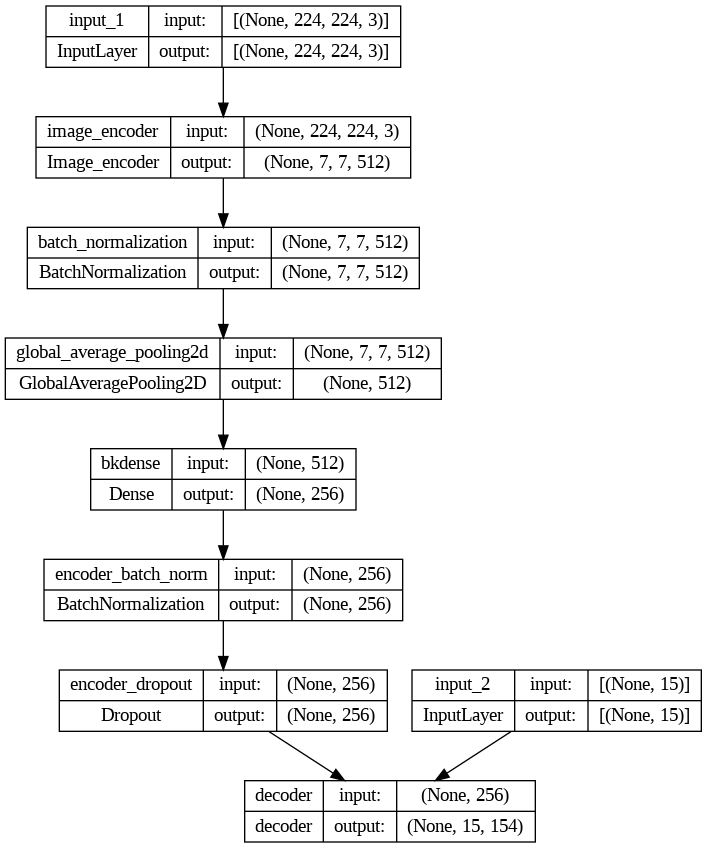

In [51]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [109]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [111]:
tf.keras.backend.clear_session()
tb_filename = 'Encoder_Decoder_global_attention/'
tb_file = os.path.join('/content/drive/MyDrive/OCT',tb_filename)
model_filename = 'Encoder_Decoder_global_attention.h5'
model_save = os.path.join('/content/drive/MyDrive/OCT',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [110]:
!rm -r '/content/drive/MyDrive/OCT/Encoder_Decoder_global_attention/'

In [112]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 20,
          callbacks = my_callbacks
          )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 3.0039 - accuracy: 0.4157
Epoch 1: val_loss improved from inf to 2.76367, saving model to /content/drive/MyDrive/OCT/Encoder_Decoder_global_attention.h5
33/33 [==============================] - 25s 466ms/step - loss: 3.0039 - accuracy: 0.4157 - val_loss: 2.7637 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 2.4558 - accuracy: 0.5399
Epoch 2: val_loss improved from 2.76367 to 2.54672, saving model to /content/drive/MyDrive/OCT/Encoder_Decoder_global_attention.h5
33/33 [==============================] - 12s 363ms/step - loss: 2.4558 - accuracy: 0.5399 - val_loss: 2.5467 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 2.0963 - accuracy: 0.6222
Epoch 3: val_loss improved from 2.54672 to 2.34002, saving model to /content/drive/MyDrive/OCT/Encoder_Decoder_global_attention.h5
33/33 [==============================] 

In [113]:
model_filename = 'Encoder_Decoder_global_attention.h5'
model_save = os.path.join('/content/drive/MyDrive/OCT',model_filename)
model1 = tf.keras.Model(inputs = [image,caption], outputs = output)
model1.load_weights(model_save)

In [89]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
%tensorboard --logdir '/content/drive/MyDrive/OCT/Encoder_Decoder_global_attention/'

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-06-04 09:01:57.084167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the s

In [62]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [63]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

In [92]:
def greedy_search_predict(image,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image = cv2.imread(image)/255 
  image = tf.expand_dims(cv2.resize(image,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image = model.get_layer('image_encoder')(image)
  image_norm = model.get_layer('batch_normalization')(image)
  image_global = model.get_layer('global_average_pooling2d')(image_norm)
  image_dense = model.get_layer('bkdense')(image_global)
  enc_op = model.get_layer('encoder_dropout')(image_dense) #this is the output from encoder
  print(enc_op.shape)


  decoder_h,decoder_c = tf.zeros_like(enc_op),tf.zeros_like(enc_op)
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<CLS>'])) #shape: (1,1)
    output,decoder_h,attention_weights = model.get_layer('decoder').onestepdecoder(caption,enc_op,decoder_h)#,decoder_c) decoder_c,

    #prediction
    max_prob = tf.argmax(output,axis=-1)  #tf.Tensor of shape = (1,1)
    caption = np.array([max_prob]) #will be sent to onstepdecoder for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences([''])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0].split("<END>")[0].strip() #here output would be 1,1 so subscripting to open the array

In [121]:
%%time
k=1
image = test['image'].iloc[k]
print(greedy_search_predict(image,model=model1))

(1, 512)
Other disease with distorted vascular area , possible ichemia and deformed vacula area .
CPU times: user 72.8 ms, sys: 1.46 ms, total: 74.3 ms
Wall time: 69.7 ms


In [122]:
%%time
_ = mean_bleu(test,greedy_search_predict)

(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
(1, 256)
CPU times: user 3.12 s, sys: 160 ms, total: 3.28 s
Wall time: 3.1 s


In [123]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.101391,0.030722,0.020385,0.004401
